# DATA SET 3 : CHIFFRES CLES COVID

In [5]:
import numpy as np
import pandas as pd
from functools import reduce

import matplotlib.pyplot as plt
%matplotlib inline

In [83]:
data = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/0b66ca39-1623-4d9c-83ad-5434b7f9e2a4", sep =",")
print(data.shape)
data = data.drop_duplicates() 
print(data.shape)


(35336, 20)
(35331, 20)


C:\Users\agros\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (17,18) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


On a un problème dans le cas où deux sources sont redondantes, mais que l'une apporte plus d'information que l'autre. La solution retenue ici est de recréer une base de données par source, pour chacune des échelles considérées, puis de fusionner les bases en utilisant la date comme clé. 

On va maintenant procéder à l'étude de la base de données à des niveaux de granularité progressifs. 

In [779]:
print(pd.unique(data["granularite"]))

['departement' 'pays' 'region' 'monde' 'collectivite-outremer']


On cherchera à représenter l'évolution du nombre de cas de covid à des échelles de plus en plus fines. Par souci de concision, on ne traitera pas ici la granularité 'collectivité d'outremer'.

In [84]:
data["date"] = pd.to_datetime(data['date'], errors='coerce')
data['mois'] = data_fra['date'].dt.month

## Echelle Mondiale

In [85]:
print(pd.unique(data[data["maille_code"] == "WORLD"]["source_type"]))

data_monde = data[data["maille_code"] == "WORLD"]
data_spf = data_monde[data_monde["source_type"] == "sante-publique-france"]
data_ms  =data_monde[data_monde["source_type"] == "ministere-sante"]
print(len(data_spf))
print(len(data_ms))

data_monde = pd.merge(data_spf, data_ms, on ="date", how ="outer")
print(len(data_monde))

['sante-publique-france' 'ministere-sante']
43
40
57


In [86]:
print(pd.unique(data[data["maille_code"] == 'WORLD']['reanimation']))
print(pd.unique(data[data["maille_code"] == 'WORLD']['depistes']))
print(pd.unique(data[data["maille_code"] == 'WORLD']['reanimation']))
print(pd.unique(data[data["maille_code"] == 'WORLD']['depistes']))

#A l'échelle du monde, on dispose seulement d'information sur les cas confirmés et les décès. 
#On décide donc de prendre le maximum des deux sources dont on dispose quand c'est possible, et de conserver uniquement les non NA dans l'autre cas. 
#Considérer l'échelle du mois pour l'évolution mondiale des cas n'est pas pertinente, car on n'a plus d'entrées après mars. 


data_monde['cas_confirmes'] = data_monde[["cas_confirmes_x", "cas_confirmes_y"]].agg(max, axis="columns")
data_monde['deces'] = data_monde[["deces_x", "deces_y"]].agg(max, axis="columns")

data_monde = data_monde[['deces', 'cas_confirmes', 'date']]

[nan]
[nan]
[nan]
[nan]


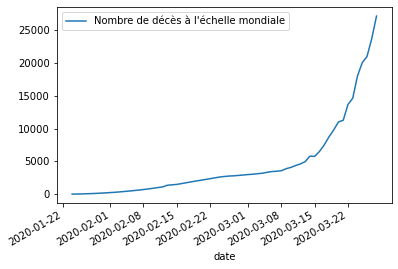

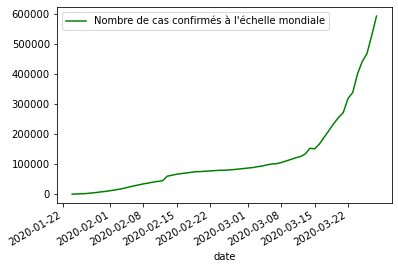

In [87]:
data_monde.plot(x = 'date', y = ['deces'])
plt.legend(["Nombre de décès à l'échelle mondiale"])

data_monde.plot(x = 'date', y = ['cas_confirmes'], color ="green")
plt.legend(["Nombre de cas confirmés à l'échelle mondiale"])

In [82]:
print(min(data_monde["date"]))
print(max(data_monde["date"]))

2020-01-24 00:00:00
2020-03-28 00:00:00


Les données ne semblent pas très bien renseignées. La période couverte par le jeu de données comprend uniquement les mois de janvier, février et mars. Sans surprise, les courbes de décès et de cas confirmés sont d'allure identique, ce qui peut être dû à un biais de saisie de données. 

## Echelle nationale

In [88]:
print(pd.unique(data[data["granularite"] == 'pays']["maille_code"]))

['FRA']


Le jeu de données, provenant de data.gouv, ne contient que des informations sur la France. 

In [90]:
print(pd.unique(data[data["maille_code"] == "FRA"]["source_type"]))

#On dispose de trois sources différentes pour la France : sante-publique-france' 'ministere-sante' 'opencovid19-fr'

data_fra = data[data["maille_code"] == "FRA"]
data_spf = data_fra[data_fra["source_type"] == "sante-publique-france"]
data_ms  =data_fra[data_fra["source_type"] == "ministere-sante"]
data_oc  =data_fra[data_fra["source_type"] == "opencovid19-fr"]

print(len(data_spf))
print(len(data_ms))
print(len(data_oc))

liste_df = [data_spf, data_ms, data_oc]

data_fra = reduce(lambda left,right: pd.merge(left, right, on='date',left_index=True, right_index=True, how='outer'), liste_df)
print(len(data_fra))
print(data_fra.columns)

['sante-publique-france' 'ministere-sante' 'opencovid19-fr']
48
308
266
622
Index(['date', 'granularite_x', 'maille_code_x', 'maille_nom_x',
       'cas_confirmes_x', 'cas_ehpad_x', 'cas_confirmes_ehpad_x',
       'cas_possibles_ehpad_x', 'deces_x', 'deces_ehpad_x', 'reanimation_x',
       'hospitalises_x', 'nouvelles_hospitalisations_x',
       'nouvelles_reanimations_x', 'gueris_x', 'depistes_x', 'source_nom_x',
       'source_url_x', 'source_archive_x', 'source_type_x', 'mois_x',
       'granularite_y', 'maille_code_y', 'maille_nom_y', 'cas_confirmes_y',
       'cas_ehpad_y', 'cas_confirmes_ehpad_y', 'cas_possibles_ehpad_y',
       'deces_y', 'deces_ehpad_y', 'reanimation_y', 'hospitalises_y',
       'nouvelles_hospitalisations_y', 'nouvelles_reanimations_y', 'gueris_y',
       'depistes_y', 'source_nom_y', 'source_url_y', 'source_archive_y',
       'source_type_y', 'mois_y', 'granularite', 'maille_code', 'maille_nom',
       'cas_confirmes', 'cas_ehpad', 'cas_confirmes_ehpad',
    

On choisit de se concentrer sur les modalités qui ne sont pas liées aux EHPAD, et d'afficher les séries temporelles. 

In [91]:
data_fra['deces'] = data_fra[["deces_x", "deces_y", 'deces']].agg(max, axis="columns")
data_fra['cas_confirmes'] = data_fra[["cas_confirmes_x", "cas_confirmes_y", 'cas_confirmes']].agg(max, axis="columns")
data_fra['hospitalises'] = data_fra[["hospitalises", "hospitalises_y", 'hospitalises_x']].agg(max, axis="columns")
data_fra['reanimation'] = data_fra[["reanimation_x", "reanimation_y", 'reanimation']].agg(max, axis="columns")
data_fra['gueris'] = data_fra[["gueris", "gueris_y", 'gueris_x']].agg(max, axis="columns")
data_fra['depistes'] = data_fra[["depistes", "depistes_y", 'depistes_x']].agg(max, axis="columns")
data_fra['nouvelles_hospitalisations'] = data_fra[['nouvelles_hospitalisations', 'nouvelles_hospitalisations_y', 'nouvelles_hospitalisations_x']].agg(max, axis="columns")
data_fra['nouvelles_reanimations'] = data_fra[['nouvelles_reanimations', 'nouvelles_reanimations_y', 'nouvelles_reanimations_x']].agg(max, axis="columns")
data_fra = data_fra[["deces", "cas_confirmes", "hospitalises", 'reanimation','nouvelles_hospitalisations','nouvelles_reanimations', 'gueris' ,'date', 'depistes']]
data_fra

,deces,cas_confirmes,hospitalises,reanimation,nouvelles_hospitalisations,nouvelles_reanimations,gueris,date,depistes
13,0.0,3.0,3.0,NaN,NaN,NaN,NaN,2020-01-24,NaN
14,0.0,3.0,3.0,NaN,NaN,NaN,NaN,2020-01-24,NaN
22,0.0,3.0,NaN,NaN,NaN,NaN,NaN,2020-01-25,NaN
27,NaN,3.0,NaN,NaN,NaN,NaN,NaN,2020-01-26,NaN
33,0.0,3.0,NaN,NaN,NaN,NaN,NaN,2020-01-27,NaN
...,...,...,...,...,...,...,...,...,...
35075,37970.0,NaN,26262.0,3210.0,627.0,101.0,169555.0,2020-12-06,NaN
35195,38362.0,2295908.0,26365.0,3198.0,1200.0,202.0,170285.0,2020-12-07,NaN
35196,38336.0,NaN,26333.0,3188.0,1206.0,203.0,170254.0,2020-12-07,NaN
35316,38739.0,2309621.0,25914.0,3088.0,1587.0,214.0,171868.0,2020-12-08,NaN


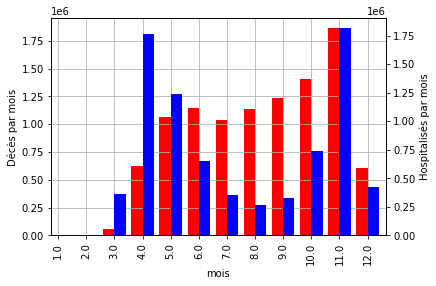

In [92]:
data_fra["date"] = pd.to_datetime(data['date'], errors='coerce')
data_fra['mois'] = data_fra['date'].dt.month


#Visualisation des données françaises, à l'échelle du mois
deces_mois = data_fra.groupby(['mois'])['deces'].sum()
cas_mois = data_fra.groupby(['mois'])['hospitalises'].sum()

fig = plt.figure()

ax = fig.add_subplot(111) 
ax2 = ax.twinx() 

width = 0.4

deces_mois.plot(kind='bar', color='red', ax=ax, width=width, position=1, grid = True)
cas_mois.plot(kind='bar', color='blue', ax=ax2, width=width, position=0)

ax.set_ylabel('Décès par mois')
ax2.set_ylabel('Hospitalisés par mois')

plt.show()


<ipython-input-93-1c65ffe61890>:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  base_jour_1= data_fra.groupby(['date'])['deces', 'reanimation', 'depistes'].sum()
<ipython-input-93-1c65ffe61890>:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  base_jour_2= data_fra.groupby(['date'])['nouvelles_reanimations', 'nouvelles_hospitalisations' ].sum()
<ipython-input-93-1c65ffe61890>:10: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  base_jour_3= data_fra.groupby(['date'])['gueris', 'depistes' ].sum()


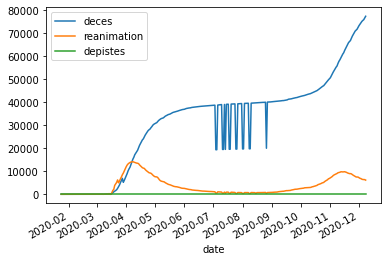

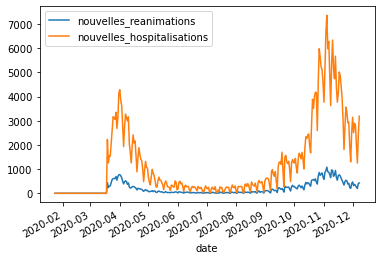

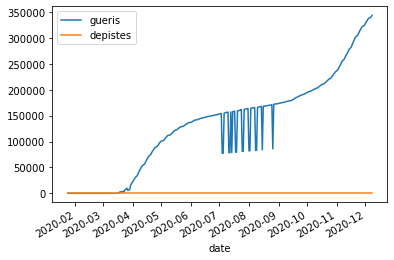

In [93]:
#Visualisation des données en France, à l'échelle quotidienne

base_jour_1= data_fra.groupby(['date'])['deces', 'reanimation', 'depistes'].sum()
base_jour_1.plot()


base_jour_2= data_fra.groupby(['date'])['nouvelles_reanimations', 'nouvelles_hospitalisations' ].sum()
base_jour_2.plot()

base_jour_3= data_fra.groupby(['date'])['gueris', 'depistes' ].sum()

base_jour_3.plot()


Les données vont du 24 janvier 2020 au 7 décembre 2020. 

# # Echelle régionale

In [94]:
print(pd.unique(data[data["granularite"] == "region"]["maille_nom"]))
print(len(pd.unique(data[data["granularite"] == "region"]["maille_code"])))

['Île-de-France' 'Nouvelle-Aquitaine' 'Auvergne-Rhône-Alpes'
 'Bourgogne-Franche-Comté' 'Hauts-de-France' 'Grand Est' 'Guadeloupe'
 'Martinique' 'Guyane' 'La Réunion' 'Mayotte' 'Centre-Val de Loire'
 'Normandie' 'Pays de la Loire' 'Bretagne' 'Occitanie'
 "Provence-Alpes-Côte d'Azur" 'Corse']
18


Les 18 régions françaises sont représentées dans cette base. Par souci d'efficacité, et parce que la redondance des sources complique l'étude de la base de données, on décide de représenter l'évolution de la pandémie dans une région typique (la médiane), et dans les régions extrêmes : celle qui compte le moins de cas, et celle qui en compte le plus. 

In [16]:
print(sum(data[data["granularite"] == "region"]["deces"].isna()))
print(sum(data[data["granularite"] == "region"]["cas_confirmes"].isna()))
print(sum(data[data["granularite"] == "region"]['cas_ehpad'].isna()))
print(sum(data[data["granularite"] == "region"]['cas_confirmes_ehpad'].isna()))
print(sum(data[data["granularite"] == "region"]['cas_possibles_ehpad'].isna()))
print(sum(data[data["granularite"] == "region"]['deces_ehpad'].isna()))
print(sum(data[data["granularite"] == "region"]['hospitalises'].isna()))
print(sum(data[data["granularite"] == "region"]['reanimation'].isna()))
print(sum(data[data["granularite"] == "region"]['nouvelles_hospitalisations'].isna()))
print(sum(data[data["granularite"] == "region"]['nouvelles_reanimations'].isna()))
print(sum(data[data["granularite"] == "region"]['gueris'].isna()))

538
4814
5601
5601
5601
5601
666
648
831
831
685


La variable qui est la plus renseignée pour la granularité régionale est le nombre de décès. C'est donc cette variable qu'on va considérer pour déterminer les individus typiques et extremaux. Pour ce calcul, on va sommer toutes les sources entre elles, ce qui conduit à un résultat très largement surestimé. On considère cependant que comme on tient compte de la relation d'ordre, la médiane reste un indicateur relativement pertinent. 

In [95]:
base_région= pd.DataFrame(data[data["granularite"] == "region"].groupby(['maille_nom'])['deces'].sum())
base_région
print(base_région.idxmax())
print(base_région.idxmin())

def mediane(x):
    return(np.quantile(x,0.5))

print(mediane(base_région))

def closest(lst, K): 
      
    return lst[min(range(len(lst)), key = lambda i: abs(lst[i]-K))] 

val_med = closest(base_région["deces"], mediane(base_région))

print(base_région[base_région["deces"] == val_med])

deces    Île-de-France
dtype: object
deces    La Réunion
dtype: object
128278.0
                       deces
maille_nom                  
Nouvelle-Aquitaine  128048.0


On va donc représenter les différentes séries temporelles dont on dispose pour l'Ile de France (valeur maximale), la Réunion (cas minimal) et l'Aquitaine (cas médian). Pour ces trois régions, on doit donc constituer des sources fiables, en procédant comme on l'a fait précedemment pour les échelles mondiales et nationales. 

In [97]:
#Nouvelle Aquitaine

print(pd.unique(data[data["maille_nom"] == "Nouvelle-Aquitaine"]["source_type"]))

#On dispose de quatres sources différentes pour la NA : sante-publique-france' 'ministere-sante' 'opencovid19-fr' 'agences-regionales-sante'

data_na = data[data["maille_nom"] == "Nouvelle-Aquitaine"]
data_spf = data_na[data_na["source_type"] == "sante-publique-france"]
data_ms  =data_na[data_na["source_type"] == "ministere-sante"]
data_oc  =data_na[data_na["source_type"] == "opencovid19-fr"]
data_ars  =data_na[data_na["source_type"] == 'agences-regionales-sante']

print(len(data_spf))
print(len(data_ms))
print(len(data_oc))

liste_df = [data_spf, data_ms, data_oc, data_ars]

data_na = reduce(lambda left,right: pd.merge(left, right, on='date',left_index=True, right_index=True, how='outer'), liste_df)
print(len(data_na))
print(data_na.columns)

['agences-regionales-sante' 'sante-publique-france' 'ministere-sante'
 'opencovid19-fr']
40
1
266
333
Index(['date', 'granularite_x', 'maille_code_x', 'maille_nom_x',
       'cas_confirmes_x', 'cas_ehpad_x', 'cas_confirmes_ehpad_x',
       'cas_possibles_ehpad_x', 'deces_x', 'deces_ehpad_x', 'reanimation_x',
       'hospitalises_x', 'nouvelles_hospitalisations_x',
       'nouvelles_reanimations_x', 'gueris_x', 'depistes_x', 'source_nom_x',
       'source_url_x', 'source_archive_x', 'source_type_x', 'mois_x',
       'granularite_y', 'maille_code_y', 'maille_nom_y', 'cas_confirmes_y',
       'cas_ehpad_y', 'cas_confirmes_ehpad_y', 'cas_possibles_ehpad_y',
       'deces_y', 'deces_ehpad_y', 'reanimation_y', 'hospitalises_y',
       'nouvelles_hospitalisations_y', 'nouvelles_reanimations_y', 'gueris_y',
       'depistes_y', 'source_nom_y', 'source_url_y', 'source_archive_y',
       'source_type_y', 'mois_y', 'granularite_x', 'maille_code_x',
       'maille_nom_x', 'cas_confirmes_x', 'cas_e

In [98]:
print(pd.unique(data[data["maille_nom"] == "La Réunion"]["source_type"]))

#On dispose de six sources différentes pour la Réunion 

data_lr = data[data["maille_nom"] == "La Réunion"]
data_spf = data_lr[data_lr["source_type"] == "sante-publique-france"]
data_ms  =data_lr[data_lr["source_type"] == "ministere-sante"]
data_oc  =data_lr[data_lr["source_type"] == "opencovid19-fr"]
data_ars  =data_lr[data_lr["source_type"] == 'agences-regionales-sante']
data_spfd = data_lr[data_lr["source_type"] == "sante-publique-france-data"]
data_lp = data_lr[data_lr["source_type"] == 'lperez31-historical-data']

liste_df = [data_spf, data_spfd, data_lp, data_ms, data_oc, data_ars]

data_lr = reduce(lambda left,right: pd.merge(left, right, on='date',left_index=True, right_index=True, how='outer'), liste_df)
print(len(data_lr))
print(data_lr.columns)

['sante-publique-france' 'agences-regionales-sante'
 'lperez31-historical-data' 'sante-publique-france-data' 'opencovid19-fr'
 'ministere-sante']
575
Index(['date', 'granularite_x', 'maille_code_x', 'maille_nom_x',
       'cas_confirmes_x', 'cas_ehpad_x', 'cas_confirmes_ehpad_x',
       'cas_possibles_ehpad_x', 'deces_x', 'deces_ehpad_x',
       ...
       'hospitalises_y', 'nouvelles_hospitalisations_y',
       'nouvelles_reanimations_y', 'gueris_y', 'depistes_y', 'source_nom_y',
       'source_url_y', 'source_archive_y', 'source_type_y', 'mois_y'],
      dtype='object', length=121)


In [99]:
print(pd.unique(data[data["maille_nom"] == "Île-de-France"]["source_type"]))

#On dispose de quatre sources différentes pour l'Ile-de-France

data_idf = data[data["maille_nom"] == 'Île-de-France']
data_spf = data_idf[data_idf["source_type"] == "sante-publique-france"]
data_ms  =data_idf[data_idf["source_type"] == "ministere-sante"]
data_oc  =data_idf[data_idf["source_type"] == "opencovid19-fr"]
data_ars  =data_idf[data_idf["source_type"] == 'agences-regionales-sante']

liste_df = [data_spf, data_ms, data_oc, data_ars]

data_idf = reduce(lambda left,right: pd.merge(left, right, on='date',left_index=True, right_index=True, how='outer'), liste_df)
print(len(data_idf))
print(data_idf.columns)

['sante-publique-france' 'ministere-sante' 'agences-regionales-sante'
 'opencovid19-fr']
317
Index(['date', 'granularite_x', 'maille_code_x', 'maille_nom_x',
       'cas_confirmes_x', 'cas_ehpad_x', 'cas_confirmes_ehpad_x',
       'cas_possibles_ehpad_x', 'deces_x', 'deces_ehpad_x', 'reanimation_x',
       'hospitalises_x', 'nouvelles_hospitalisations_x',
       'nouvelles_reanimations_x', 'gueris_x', 'depistes_x', 'source_nom_x',
       'source_url_x', 'source_archive_x', 'source_type_x', 'mois_x',
       'granularite_y', 'maille_code_y', 'maille_nom_y', 'cas_confirmes_y',
       'cas_ehpad_y', 'cas_confirmes_ehpad_y', 'cas_possibles_ehpad_y',
       'deces_y', 'deces_ehpad_y', 'reanimation_y', 'hospitalises_y',
       'nouvelles_hospitalisations_y', 'nouvelles_reanimations_y', 'gueris_y',
       'depistes_y', 'source_nom_y', 'source_url_y', 'source_archive_y',
       'source_type_y', 'mois_y', 'granularite_x', 'maille_code_x',
       'maille_nom_x', 'cas_confirmes_x', 'cas_ehpad_x',


On choisit de représenter uniquement les décès et cas confirmés pour chacune des trois régions déterminées. 

In [101]:
#IDF 
data_idf['deces'] = data_idf[["deces_x", "deces_y", 'deces_x','deces_y']].agg(max, axis="columns")
data_idf['cas_confirmes'] = data_idf[["cas_confirmes_x", "cas_confirmes_y","cas_confirmes_x", "cas_confirmes_y"]].agg(max, axis="columns")
data_idf = data_idf[['deces' , 'cas_confirmes', 'date']]
data_idf

#NA
data_na['deces'] = data_na[["deces_x", "deces_y", 'deces_x','deces_y']].agg(max, axis="columns")
data_na['cas_confirmes'] = data_na[["cas_confirmes_x", "cas_confirmes_y","cas_confirmes_x", "cas_confirmes_y"]].agg(max, axis="columns")
data_na = data_na[['deces' , 'cas_confirmes', 'date']]

#LR
data_lr['deces'] = data_lr[["deces_x", "deces_y", 'deces_x','deces_y', 'deces_x','deces_y']].agg(max, axis="columns")
data_lr['cas_confirmes'] = data_lr[["cas_confirmes_x", "cas_confirmes_y","cas_confirmes_x", "cas_confirmes_y", "cas_confirmes_x", "cas_confirmes_y"]].agg(max, axis="columns")
data_lr = data_lr[['deces' , 'cas_confirmes', 'date']]

KeyError: "None of [Index(['deces_x', 'deces_y', 'deces_x', 'deces_y'], dtype='object')] are in the [columns]"

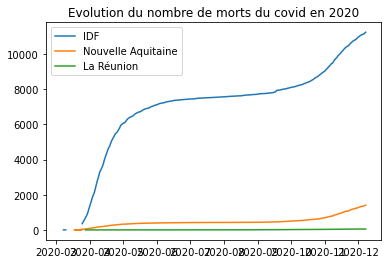

In [102]:
plt.plot(data_idf["date"], data_idf['deces'])
plt.plot(data_na["date"], data_na["deces"])
plt.plot(data_lr["date"], data_lr["deces"])
plt.title('Evolution du nombre de morts du covid en 2020')
plt.legend(['IDF', 'Nouvelle Aquitaine', 'La Réunion'])  

(0.0, 3000.0)

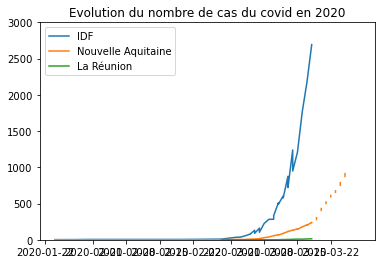

In [103]:
plt.plot(data_idf["date"], data_idf['cas_confirmes'])
plt.plot(data_na["date"], data_na["cas_confirmes"])
plt.plot(data_lr["date"], data_lr["cas_confirmes"])
plt.title('Evolution du nombre de cas du covid en 2020')
plt.legend(['IDF', 'Nouvelle Aquitaine', 'La Réunion']) 
plt.ylim(0, 3000)

## Echelle départementale

On va procéder comme à l'échelle régionale, en cherchant à déterminer les départements extremes et le département médian.

In [104]:
base_dep = pd.DataFrame(data[data["granularite"] == "departement"].groupby(['maille_nom'])['deces'].sum())
print(base_dep.idxmax())
print(base_dep.idxmin())

def mediane(x):
    return(np.quantile(x,0.5))

print(mediane(base_dep))

def closest(lst, K): 
      
    return lst[min(range(len(lst)), key = lambda i: abs(lst[i]-K))] 

val_med = closest(base_dep["deces"], mediane(base_dep))

print(base_dep[base_dep["deces"] == val_med])

deces    Paris
dtype: object
deces    Ariège
dtype: object
23178.0
                  deces
maille_nom             
Indre-et-Loire  23178.0


On étudiera donc Paris (max), l'Ariège (min), et l'Indre-et-Loire (médiane). 

In [105]:
print(pd.unique(data[data["maille_nom"] == "Paris"]["source_type"]))

#On dispose de deux sources différentes pour Paris

data_paris = data[data["maille_nom"] == 'Paris']
data_spfd = data_paris[data_paris["source_type"] == "sante-publique-france-data"]
data_ars  =data_paris[data_paris["source_type"] == 'agences-regionales-sante']

liste_df = [data_spfd, data_ars]

data_paris = reduce(lambda left,right: pd.merge(left, right, on='date',left_index=True, right_index=True, how='outer'), liste_df)
print(len(data_paris))
print(data_paris.columns)

['agences-regionales-sante' 'sante-publique-france-data']
274
Index(['date', 'granularite_x', 'maille_code_x', 'maille_nom_x',
       'cas_confirmes_x', 'cas_ehpad_x', 'cas_confirmes_ehpad_x',
       'cas_possibles_ehpad_x', 'deces_x', 'deces_ehpad_x', 'reanimation_x',
       'hospitalises_x', 'nouvelles_hospitalisations_x',
       'nouvelles_reanimations_x', 'gueris_x', 'depistes_x', 'source_nom_x',
       'source_url_x', 'source_archive_x', 'source_type_x', 'mois_x',
       'granularite_y', 'maille_code_y', 'maille_nom_y', 'cas_confirmes_y',
       'cas_ehpad_y', 'cas_confirmes_ehpad_y', 'cas_possibles_ehpad_y',
       'deces_y', 'deces_ehpad_y', 'reanimation_y', 'hospitalises_y',
       'nouvelles_hospitalisations_y', 'nouvelles_reanimations_y', 'gueris_y',
       'depistes_y', 'source_nom_y', 'source_url_y', 'source_archive_y',
       'source_type_y', 'mois_y'],
      dtype='object')


In [106]:
print(pd.unique(data[data["maille_nom"] == "Ariège"]["source_type"]))

#On dispose de deux sources différentes pour l'Ariège

data_ar = data[data["maille_nom"] == 'Ariège']
data_spfd = data_ar[data_ar["source_type"] == "sante-publique-france-data"]
data_ars  =data_ar[data_ar["source_type"] == 'agences-regionales-sante']

liste_df = [data_spfd, data_ars]

data_ar = reduce(lambda left,right: pd.merge(left, right, on='date',left_index=True, right_index=True, how='outer'), liste_df)
print(len(data_ar))
print(data_ar.columns)

['agences-regionales-sante' 'sante-publique-france-data']
283
Index(['date', 'granularite_x', 'maille_code_x', 'maille_nom_x',
       'cas_confirmes_x', 'cas_ehpad_x', 'cas_confirmes_ehpad_x',
       'cas_possibles_ehpad_x', 'deces_x', 'deces_ehpad_x', 'reanimation_x',
       'hospitalises_x', 'nouvelles_hospitalisations_x',
       'nouvelles_reanimations_x', 'gueris_x', 'depistes_x', 'source_nom_x',
       'source_url_x', 'source_archive_x', 'source_type_x', 'mois_x',
       'granularite_y', 'maille_code_y', 'maille_nom_y', 'cas_confirmes_y',
       'cas_ehpad_y', 'cas_confirmes_ehpad_y', 'cas_possibles_ehpad_y',
       'deces_y', 'deces_ehpad_y', 'reanimation_y', 'hospitalises_y',
       'nouvelles_hospitalisations_y', 'nouvelles_reanimations_y', 'gueris_y',
       'depistes_y', 'source_nom_y', 'source_url_y', 'source_archive_y',
       'source_type_y', 'mois_y'],
      dtype='object')


In [107]:
print(pd.unique(data[data["maille_nom"] == "Indre-et-Loire"]["source_type"]))

#On dispose de 3 sources différentes pour l'Indre-et-Loire

data_il = data[data["maille_nom"] == 'Indre-et-Loire']
data_spfd = data_il[data_il["source_type"] == "sante-publique-france-data"]
data_ars  =data_il[data_il["source_type"] == 'agences-regionales-sante']
data_lp  =data_il[data_il["source_type"] == 'lperez31-historical-data']

liste_df = [data_spfd, data_ars, data_lp]

data_il = reduce(lambda left,right: pd.merge(left, right, on='date',left_index=True, right_index=True, how='outer'), liste_df)
print(len(data_il))
print(data_il.columns)

['lperez31-historical-data' 'agences-regionales-sante'
 'sante-publique-france-data']
292
Index(['date', 'granularite_x', 'maille_code_x', 'maille_nom_x',
       'cas_confirmes_x', 'cas_ehpad_x', 'cas_confirmes_ehpad_x',
       'cas_possibles_ehpad_x', 'deces_x', 'deces_ehpad_x', 'reanimation_x',
       'hospitalises_x', 'nouvelles_hospitalisations_x',
       'nouvelles_reanimations_x', 'gueris_x', 'depistes_x', 'source_nom_x',
       'source_url_x', 'source_archive_x', 'source_type_x', 'mois_x',
       'granularite_y', 'maille_code_y', 'maille_nom_y', 'cas_confirmes_y',
       'cas_ehpad_y', 'cas_confirmes_ehpad_y', 'cas_possibles_ehpad_y',
       'deces_y', 'deces_ehpad_y', 'reanimation_y', 'hospitalises_y',
       'nouvelles_hospitalisations_y', 'nouvelles_reanimations_y', 'gueris_y',
       'depistes_y', 'source_nom_y', 'source_url_y', 'source_archive_y',
       'source_type_y', 'mois_y', 'granularite', 'maille_code', 'maille_nom',
       'cas_confirmes', 'cas_ehpad', 'cas_confirme

In [108]:
data_paris['deces'] = data_paris[["deces_x", "deces_y"]].agg(max, axis="columns")
data_paris['cas_confirmes'] = data_paris[["cas_confirmes_x", "cas_confirmes_y"]].agg(max, axis="columns")
data_paris = data_paris[['deces' , 'cas_confirmes', 'date']]

data_ar['deces'] = data_ar[["deces_x", "deces_y"]].agg(max, axis="columns")
data_ar['cas_confirmes'] = data_ar[["cas_confirmes_x", "cas_confirmes_y"]].agg(max, axis="columns")
data_ar = data_ar[['deces' , 'cas_confirmes', 'date']]

data_il['deces'] = data_il[["deces_x", "deces_y", 'deces_x']].agg(max, axis="columns")
data_il['cas_confirmes'] = data_il[["cas_confirmes_x", "cas_confirmes_y", 'cas_confirmes_x']].agg(max, axis="columns")
data_il = data_il[['deces' , 'cas_confirmes', 'date']]


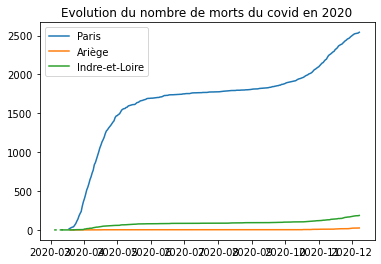

In [110]:
plt.plot(data_paris["date"], data_paris['deces'])
plt.plot(data_ar["date"], data_ar["deces"])
plt.plot(data_il["date"], data_il["deces"])
plt.title('Evolution du nombre de morts du covid en 2020')
plt.legend(['Paris', 'Ariège', 'Indre-et-Loire'])  

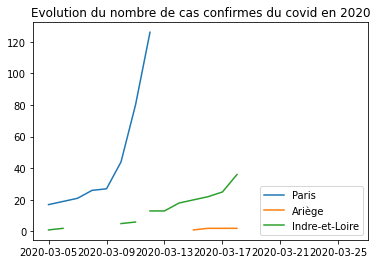

In [111]:


plt.plot(data_paris["date"], data_paris['cas_confirmes'])
plt.plot(data_ar["date"], data_ar["cas_confirmes"])
plt.plot(data_il["date"], data_il["cas_confirmes"])

plt.title('Evolution du nombre de cas confirmes du covid en 2020')
plt.legend(['Paris', 'Ariège', 'Indre-et-Loire'])  
plt.show()

On constate que les cas confirmés sont très mal renseignés à l'échelle départementale au sein de cette base de données, et ils ne sont plus renseignés du tout après les mesures de confinement de mars. 

### ANALYSE DU DATA SET 1

In [53]:
bdd_1 = pd.read_excel('dataset 1 - recherches (1).xlsx', sheet_name = 'Ensemble de données1')
bdd_2 = pd.read_excel('dataset 1 - recherches (1).xlsx', sheet_name = 'Ensemble de données2')

On commence par s'intéresser à la série temporelle de la deuxième feuille de la base de données. 

Index(['Index des jours', 'Nombre total d'événements'], dtype='object')
159


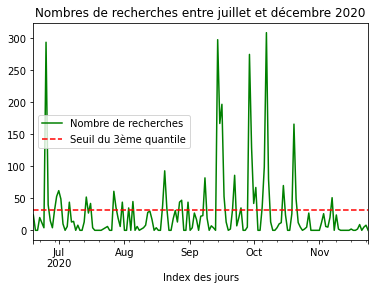

In [54]:
print(bdd_2.columns)
bdd_2 = bdd_2.rename(columns = {"Nombre total d'événements" : 'nb_recherche'})
bdd_2  = bdd_2.dropna(subset=['Index des jours'])
bdd_2.plot(x = 'Index des jours', y = ['nb_recherche'], color ="green")
plt.axhline(y = np.quantile(bdd_2["nb_recherche"], 0.75) , color='red',linestyle='--' )
plt.title('Nombres de recherches entre juillet et décembre 2020')
plt.legend(['Nombre de recherches', 'Seuil du 3ème quantile'])  
print(len(bdd_2))


In [55]:
print(min(bdd_2["Index des jours"]))
print(max(bdd_2["Index des jours"]))
print(max(bdd_2["Index des jours"]) - min(bdd_2["Index des jours"]))

2020-06-19 00:00:00
2020-11-24 00:00:00
158 days 00:00:00


In [56]:
print(bdd_2["nb_recherche"].describe())
print(max(bdd_2))

count    159.000000
mean      27.138365
std       53.558731
min        0.000000
25%        0.000000
50%        7.000000
75%       31.000000
max      309.000000
Name: nb_recherche, dtype: float64
nb_recherche


La base de données considérée fait 159 lignes, on a exactement une ligne par jour entre le 19 juin et le 24 novembre 2020. En moyenne, on comptabilise 27.13 recherches par jour, et 309 au maximum.

In [57]:
print(bdd_2["nb_recherche"].sum())
#On retrouve bien la valeur totale qui se trouvait en dernière ligne du tableau. On comptabilise 4315 recherches depuis 19 juin.

4315


In [58]:
bdd_1 = bdd_1.rename(columns = {"Libellé d'événement" : 'lib'})
bdd_1 = bdd_1.dropna(subset=['lib'])

In [59]:
bdd_1.sort_values(by = "Nombre total d'événements", ascending = False )
print(bdd_1[bdd_1["lib"] == "recherche vide"]["Nombre total d'événements"]/ bdd_1["Nombre total d'événements"].sum())
#Les recherches vides représentent 53% du nombre total d'événements
print(bdd_1[bdd_1["lib"] == "recherche vide"]["Événements uniques"]/ bdd_1["Événements uniques"].sum())
#Les recherches vides représentent 35% du total des événements uniques

0    0.526535
Name: Nombre total d'événements, dtype: float64
0    0.348028
Name: Événements uniques, dtype: float64


Le problème principal de cette base réside dans le fait que les outils ne sont pas indexés par un code, mais par des chaînes de caractère non normalisées, qui diffèrent d'une majuscule ou d'une faute d'orthographe, mais représentent le même outil dans la base. On décide donc de regrouper tous les outils recherchés qui ont les mêmes quatre premiers caractères. On va ainsi regrouper les objets du même type. Même si les objets recherchés ne sont pas identiques, on indiquera ainsi une tendance des recherches. 

In [60]:
bdd_1['code']= bdd_1['lib'].str[:4]
print(len(bdd_1))
bdd = bdd_1.groupby(['code'])[["Nombre total d'événements", "Événements uniques", 'code']].sum()
#On ne veut pas considérer 'recherche vide' donc on ne prend les valeurs qu'à partir de la deuxième ligne. 
bdd = bdd.sort_values(by = "Nombre total d'événements", ascending = False)[2:]
bdd

475


,Nombre total d'événements,Événements uniques
code,,
tran,68,17
pres,45,8
endr,31,2
Tran,30,9
elbo,28,3
...,...,...
F9A,1,1
regu,1,1
Pump,1,1


On passe ainsi de 475 à 374 lignes dans le data frame considéré

Les éléments qui sont le plus recherchés ont pour code  "tran" et "pres". 

In [62]:
bdd_1[bdd_1["code"] == "tran"]

,lib,Nombre total d'événements,Événements uniques,code
2,transformateur,48,8,tran
34,transformer,11,3,tran
193,transformateur schneider,3,2,tran
366,transformat,2,1,tran
367,transformateur 100kva,2,1,tran
462,transformateur 800,1,1,tran
465,transfromer,1,1,tran


Le code 'tran' correspond à la recherche de transformateurs. 

In [65]:
bdd_1[bdd_1["code"] == "pres"]

,lib,Nombre total d'événements,Événements uniques,code
3,pressure switch,34,1,pres
95,pressure gauge,6,3,pres
336,pressure switch CCS,2,1,pres
444,pressure gaguge,1,1,pres
445,pressure gauges,1,1,pres
446,pressure gauGES,1,1,pres


Le code 'pres' correspond à la recherche d'instruments de mesure de pression. 

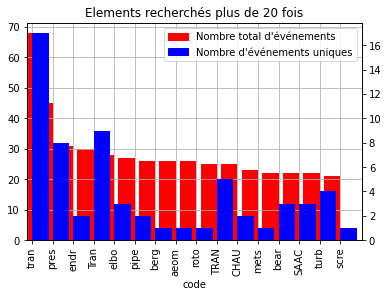

In [70]:
import matplotlib.patches as mpatches

bdd_sup = bdd[bdd["Nombre total d'événements"] > 20]
fig = plt.figure()

ax = fig.add_subplot(111) 
ax2 = ax.twinx() 

width = 0.8

bdd_sup["Nombre total d'événements"].plot(kind='bar', color='red', ax=ax, width=width, position=1, grid = True)
bdd_sup["Événements uniques"].plot(kind='bar', color='blue', ax=ax2, width=width, position=0)
red_patch = mpatches.Patch(color='red', label="Nombre total d'événements")
blue_patch = mpatches.Patch(color='blue', label="Nombre d'événements uniques")
plt.legend(handles=[red_patch, blue_patch]) 
plt.title('Elements recherchés plus de 20 fois')
plt.show()

